In [4]:
#neural network classification
import sklearn
from sklearn.datasets import make_circles

In [5]:
n_samples = 1000
X, y = make_circles(n_samples, noise = 0.04, random_state=42)

In [6]:
len(X), len(y)

(1000, 1000)

In [7]:
print(f"first 5 samples of X {X[:5]}")
print(f"first 5 samples of y {y[:5]}")

first 5 samples of X [[ 0.74822656  0.23908325]
 [-0.74509559  0.16097526]
 [-0.82262532  0.19762051]
 [-0.41143316  0.68255648]
 [ 0.44390494 -0.89582949]]
first 5 samples of y [1 1 1 1 0]


In [8]:
import pandas as pd
circles = pd.DataFrame({"X0" : X[:, 0], "X2" : X[:,1], "label" : y})
circles.head()

,X0,X2,label
0,0.748227,0.239083,1
1,-0.745096,0.160975,1
2,-0.822625,0.197621,1
3,-0.411433,0.682556,1
4,0.443905,-0.895829,0


In [9]:
## check input and output shapes
X.shape, y.shape
#turn data into tensors
import torch
torch.__version__

'2.6.0+cu124'

In [10]:
type(X)
X.dtype

dtype('float64')

In [11]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
type(X)

torch.Tensor

In [13]:
## split data into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42);

In [14]:
X_train.shape

torch.Size([800, 2])

In [15]:
# model development (device agnostic code)
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
# subclassing nn.module
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    # create the linear layer for handling our data
    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)
    #define a forward methon that outlines the forward pass
  def forward(self, x):
    return self.layer2(self.layer1(x))


In [17]:
    #instantiate an instance of our model class
model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4153, -0.6082],
                      [-0.5736,  0.6709],
                      [ 0.6655,  0.4582],
                      [-0.3330,  0.0056],
                      [-0.5782,  0.2425]], device='cuda:0')),
             ('0.bias',
              tensor([-0.2197,  0.6434,  0.5291, -0.1951, -0.3625], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0413, -0.3447,  0.3572, -0.2546, -0.3017]], device='cuda:0')),
             ('1.bias', tensor([-0.2632], device='cuda:0'))])

In [20]:
### 2.1 setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss() # this has sigmoid activation function built in
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [21]:
## calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [22]:
## checking raw logits from our model
# always check for eval mode
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits.squeeze()

tensor([-0.5220, -0.2780, -0.5886, -0.5008,  0.2624], device='cuda:0')

In [23]:
## using sigmoid activation functions on our logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs.squeeze()

tensor([0.3724, 0.4310, 0.3570, 0.3774, 0.5652], device='cuda:0')

In [24]:
torch.round(y_pred_probs).squeeze()

tensor([0., 0., 0., 0., 1.], device='cuda:0')

In [25]:
## buliding training and tesiting loops
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epoch = 100

X_train , y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epoch):
  model_0.train()
  y_logits = model_0(X_train.to(device)).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)).squeeze()

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits)).squeeze()
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

  if epoch % 10 == 0:
    print(f"Epochs : {epoch}, loss : {loss:.5f}%, acc : {acc:.2f}%, test_loss:{test_loss:.5f}%, test_acc={test_acc:.2f}%")

Epochs : 0, loss : 0.72235%, acc : 50.00%, test_loss:0.72390%, test_acc=48.00%
Epochs : 10, loss : 0.71188%, acc : 49.62%, test_loss:0.71522%, test_acc=49.50%
Epochs : 20, loss : 0.70590%, acc : 49.62%, test_loss:0.71024%, test_acc=49.00%
Epochs : 30, loss : 0.70219%, acc : 49.62%, test_loss:0.70708%, test_acc=50.50%
Epochs : 40, loss : 0.69975%, acc : 50.00%, test_loss:0.70494%, test_acc=49.00%
Epochs : 50, loss : 0.69807%, acc : 50.50%, test_loss:0.70340%, test_acc=49.00%
Epochs : 60, loss : 0.69689%, acc : 49.88%, test_loss:0.70227%, test_acc=48.50%
Epochs : 70, loss : 0.69604%, acc : 50.00%, test_loss:0.70141%, test_acc=49.50%
Epochs : 80, loss : 0.69542%, acc : 49.88%, test_loss:0.70073%, test_acc=49.50%
Epochs : 90, loss : 0.69496%, acc : 50.12%, test_loss:0.70019%, test_acc=49.00%


In [26]:
## improving a model
# Epochs : 90, loss : 0.69312%, acc : 50.75%, test_loss:0.69398%, test_acc=48.00% initially

In [27]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

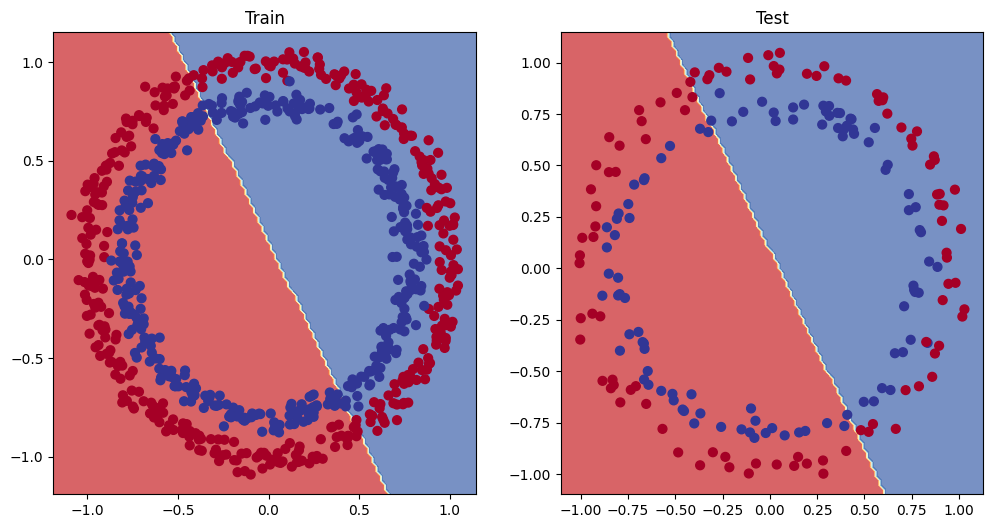

In [28]:
import matplotlib.pyplot as plt
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

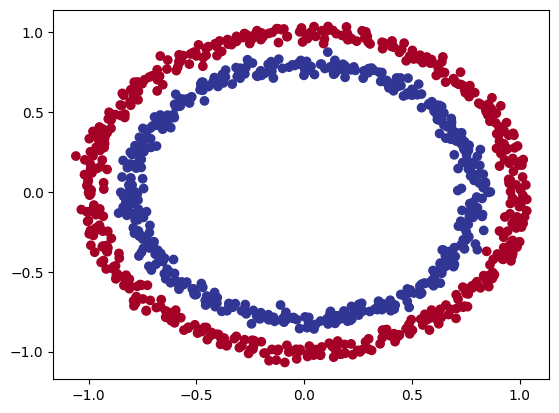

In [29]:
## adding non linearity to our model
from sklearn.datasets import make_circles
n = 1000
X, y = make_circles(n, noise=0.03,random_state=42)

plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [30]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [31]:
from torch import nn
class CircleV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=8)
    self.layer3 = nn.Linear(in_features=8, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    # return self.layer3(self.relu(self.layer1(x)))

model2 = CircleV2().to(device)
model2

CircleV2(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [32]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.1)

In [33]:
## training a model with non-linearity
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_test, y_test = X_test.to(device), y_test.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)

for epoch in range(epochs):
  model2.train()
  y_logits = model2(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)).squeeze()

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model2.eval()
  with torch.inference_mode():
    test_logits = model2(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69496, Accuracy: 50.00% | Test Loss: 0.69445, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.68861, Accuracy: 56.50% | Test Loss: 0.68765, Test Accuracy: 56.50%
Epoch: 200 | Loss: 0.68650, Accuracy: 58.13% | Test Loss: 0.68539, Test Accuracy: 63.50%
Epoch: 300 | Loss: 0.68365, Accuracy: 55.88% | Test Loss: 0.68231, Test Accuracy: 60.50%
Epoch: 400 | Loss: 0.67997, Accuracy: 56.12% | Test Loss: 0.67813, Test Accuracy: 61.00%
Epoch: 500 | Loss: 0.67520, Accuracy: 56.25% | Test Loss: 0.67259, Test Accuracy: 61.00%
Epoch: 600 | Loss: 0.66920, Accuracy: 56.12% | Test Loss: 0.66538, Test Accuracy: 61.50%
Epoch: 700 | Loss: 0.66122, Accuracy: 57.12% | Test Loss: 0.65556, Test Accuracy: 61.50%
Epoch: 800 | Loss: 0.64822, Accuracy: 58.00% | Test Loss: 0.64107, Test Accuracy: 61.50%
Epoch: 900 | Loss: 0.62285, Accuracy: 64.50% | Test Loss: 0.61546, Test Accuracy: 69.00%


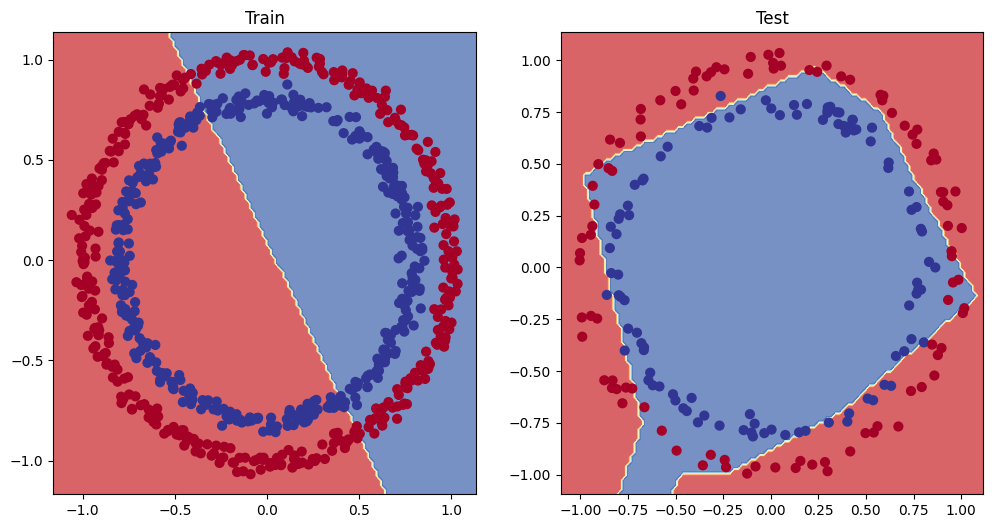

In [34]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model2, X_test, y_test)

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


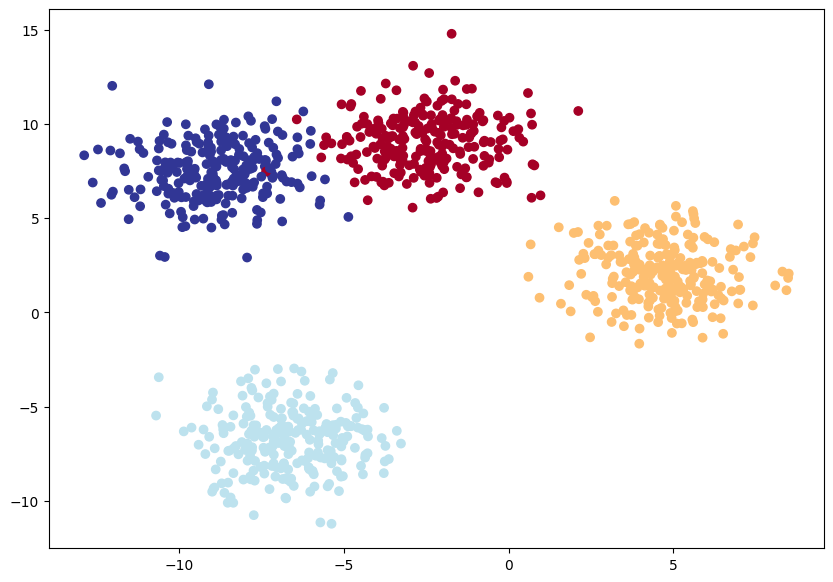

In [35]:
## multi class classification
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# making the datasets
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, cluster_std=1.5, centers=NUM_CLASSES, random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)


# visualize the data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)


In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [40]:
from torch import nn
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model3 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES).to(device)
model3



BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.01)

In [46]:
torch.manual_seed(42)
epochs = 100
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)

for epoch in range (epochs):
  model3.train()

  y_logits = model3(X_blob_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_pred=y_preds, y_true=y_blob_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model3.eval()
  with torch.inference_mode():
    test_logits = model3(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.03805, Acc: 98.88% | Test Loss: 0.02903, Test Acc: 99.50%
Epoch: 10 | Loss: 0.03790, Acc: 98.88% | Test Loss: 0.02887, Test Acc: 99.50%
Epoch: 20 | Loss: 0.03775, Acc: 98.88% | Test Loss: 0.02872, Test Acc: 99.50%
Epoch: 30 | Loss: 0.03761, Acc: 98.88% | Test Loss: 0.02856, Test Acc: 99.50%
Epoch: 40 | Loss: 0.03747, Acc: 98.88% | Test Loss: 0.02841, Test Acc: 99.50%
Epoch: 50 | Loss: 0.03733, Acc: 98.88% | Test Loss: 0.02826, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03719, Acc: 98.88% | Test Loss: 0.02812, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03706, Acc: 98.88% | Test Loss: 0.02798, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03693, Acc: 98.88% | Test Loss: 0.02784, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03680, Acc: 98.88% | Test Loss: 0.02770, Test Acc: 99.50%


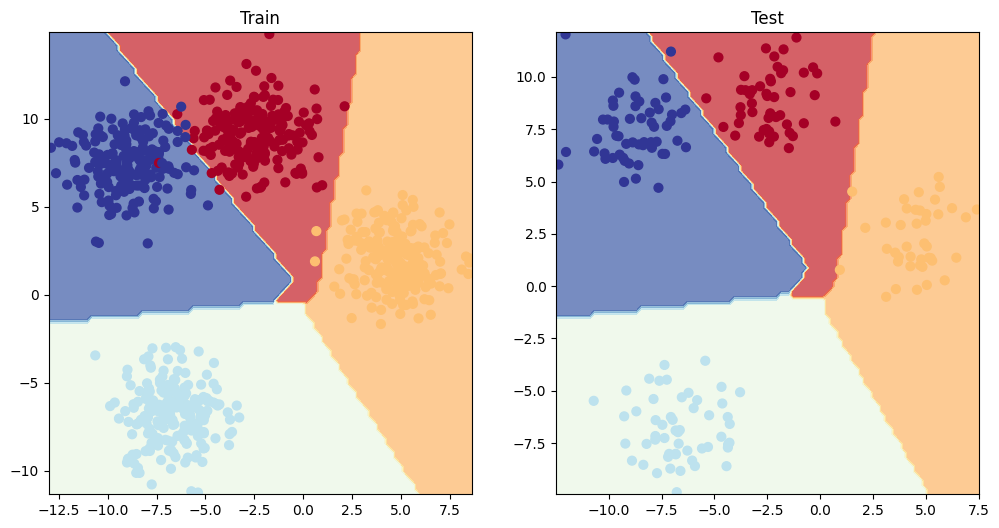

In [49]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model3, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, X_blob_test, y_blob_test)